In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from businessscoring import businessgain
from sklearn.metrics import make_scorer

In [2]:
from Feature_Engineering import feature_engineering

In [3]:
features = feature_engineering(j_flag=0) # For the full dataset

In [4]:
features.shape
recall_scores = pd.DataFrame(columns=('Model', 'Score'))

In [5]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [6]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [7]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['Both_Service', 'Inpatient', 'Outpatient',\
            'isFraudConnected']]

#drop dummy variables
X = X.drop(['Both_Service', 'Inpatient', 'Outpatient',\
           'isFraudConnected'], axis =1)

In [8]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,ChronicCond_IschemicHeart_1,ChronicCond_IschemicHeart_2,ChronicCond_Osteoporasis_1,ChronicCond_Osteoporasis_2,ChronicCond_rheumatoidarthritis_1,ChronicCond_rheumatoidarthritis_2,ChronicCond_stroke_1,ChronicCond_stroke_2,NetworkDegree,NoPhysicianCount
0,0.470588,-0.017544,-0.155665,-0.086957,-0.184866,1.142857,-0.114286,1.833333,-1.833333,-0.081081,...,0.095238,-0.266667,-0.111111,0.025641,0.055556,-0.025641,0.500000,-0.057971,0.333333,0.0
1,2.235294,1.614035,0.031527,1.443478,0.030651,13.857143,0.714286,3.833333,-3.833333,1.783784,...,1.928571,0.800000,1.111111,1.846154,1.388889,1.743590,1.166667,1.661836,0.000000,0.0
2,1.882353,1.982456,0.222660,1.582609,0.143678,0.000000,1.790476,0.000000,0.000000,1.756757,...,1.904762,2.266667,1.944444,2.000000,1.888889,2.051282,2.333333,1.932367,0.666667,0.0
3,0.000000,8.245614,15.763547,13.034783,24.233716,0.000000,14.333333,0.000000,0.000000,9.945946,...,7.833333,9.466667,7.444444,8.615385,6.666667,9.000000,6.166667,8.386473,-0.333333,2.0
4,0.235294,0.578947,0.650246,0.530435,0.593870,0.857143,0.580952,0.500000,-0.500000,0.567568,...,0.523810,0.800000,0.500000,0.615385,0.500000,0.641026,1.166667,0.521739,1.333333,0.0


In [9]:
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,ChronicCond_rheumatoidarthritis_1,ChronicCond_rheumatoidarthritis_2,ChronicCond_stroke_1,ChronicCond_stroke_2,NetworkDegree,NoPhysicianCount,Both_Service,Inpatient,Outpatient,isFraudConnected
0,0.470588,-0.017544,-0.155665,-0.086957,-0.184866,1.142857,-0.114286,1.833333,-1.833333,-0.081081,...,0.055556,-0.025641,0.500000,-0.057971,0.333333,0.0,1,0,0,0.0
1,2.235294,1.614035,0.031527,1.443478,0.030651,13.857143,0.714286,3.833333,-3.833333,1.783784,...,1.388889,1.743590,1.166667,1.661836,0.000000,0.0,1,0,0,1.0
2,1.882353,1.982456,0.222660,1.582609,0.143678,0.000000,1.790476,0.000000,0.000000,1.756757,...,1.888889,2.051282,2.333333,1.932367,0.666667,0.0,0,0,1,0.0
3,0.000000,8.245614,15.763547,13.034783,24.233716,0.000000,14.333333,0.000000,0.000000,9.945946,...,6.666667,9.000000,6.166667,8.386473,-0.333333,2.0,0,0,1,0.0
4,0.235294,0.578947,0.650246,0.530435,0.593870,0.857143,0.580952,0.500000,-0.500000,0.567568,...,0.500000,0.641026,1.166667,0.521739,1.333333,0.0,1,0,0,0.0


In [10]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

### Examining VIF

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_Bal.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [round(variance_inflation_factor(X_train_Bal.values, i),3)
                          for i in range(len(X_train_Bal.columns))] 
  
print(vif_data)

/home/annie/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                              feature          VIF
0                          Phys_Count        3.382
1                       Patient_Count          inf
2                  Norm_Patient_Count       38.866
3                         Claim_Count          inf
4                    Norm_Claim_Count       42.720
5                     Inpatient_Count          inf
6                    Outpatient_Count          inf
7                Norm_Inpatient_Count  7773210.338
8               Norm_Outpatient_Count  7773127.854
9                     DuplicateClaims       34.763
10           Duplicate_Claims_Percent        1.207
11                   AvgClaimDuration        2.439
12                           Avg_Cost        6.906
13                            Avg_Age        1.015
14                            Gender1          inf
15                            Gender2          inf
16                              Race1          inf
17                              Race2          inf
18                             

### Examining Correlation Matrix

In [14]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
plt.style.use('ggplot')

In [16]:
business_score = make_scorer(businessgain, 
                            greater_is_better=True)

#### SMOTE balanced data

In [17]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline recall score:  0.9207920792079208


In [18]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 546 ms, sys: 74.9 ms, total: 621 ms
Wall time: 6.06 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring=make_scorer(businessgain))

In [19]:
#SMOTE
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
SMOTE_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 1.5}
Logistic Regression Grid Search train recall score:  0.9140102358953361
Logistic Best Estimator Validation set recall score:  0.9207920792079208
Logistic Best Estimator Validation set business score:  0.8139003741348096


#### imblearn balanced dataset

In [20]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline recall score:  0.9504950495049505


In [21]:
grid_para_logit = {
    'C': np.linspace(0,2,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 458 ms, sys: 23.8 ms, total: 482 ms
Wall time: 6.06 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.10526316, 0.21052632, 0.31578947, 0.42105263,
       0.52631579, 0.63157895, 0.73684211, 0.84210526, 0.94736842,
       1.05263158, 1.15789474, 1.26315789, 1.36842105, 1.47368421,
       1.57894737, 1.68421053, 1.78947368, 1.89473684, 2.        ])},
             scoring=make_scorer(businessgain))

In [22]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 2.0}
Logistic Regression Grid Search train recall score:  0.8832595925660686
Logistic Best Estimator Validation set recall score:  0.9603960396039604
Logistic Best Estimator Validation set business score:  0.8866487452613148


#### Comparing SMOTE and imblearn

In [23]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.8139003741348096 
imblearn logit business score:  0.8866487452613148


In [137]:
recall_scores.loc[0] = 'Logistic', round(SMOTE_logit, 2)

#### feature importance for logistic regression

,Feature,Score
45,isFraudConnected,14.869244
40,NetworkDegree,4.272186
44,Outpatient,1.931311
3,Claim_Count,0.980822
6,Outpatient_Count,0.887341
9,DuplicateClaims,0.875644
28,ChronicCond_Depression_1,0.828496
29,ChronicCond_Depression_2,0.751362
43,Inpatient,0.697275
38,ChronicCond_stroke_1,0.404010


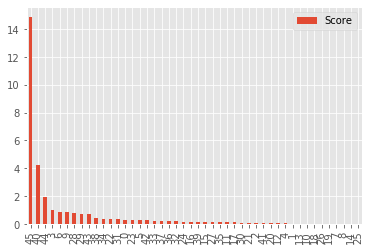

In [34]:
importance = logit_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent Classifier

In [33]:
from sklearn.linear_model import SGDClassifier

#### SMOTE

In [120]:
# SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline recall score:  0.9900990099009901


In [123]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(1e-4,1e-6,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 2.79 s, sys: 75.4 ms, total: 2.87 s
Wall time: 13.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 9.65862069e-05, 9.31724138e-05, 8.97586207e-05,
       8.63448276e-05, 8.29310345e-05, 7.95172414e-05, 7.61034483e-05,
       7.26896552e-05, 6.92758621e-05, 6.58620690e-...
       5.90344828e-05, 5.56206897e-05, 5.22068966e-05, 4.87931034e-05,
       4.53793103e-05, 4.19655172e-05, 3.85517241e-05, 3.51379310e-05,
       3.17241379e-05, 2.83103448e-05, 2.48965517e-05, 2.14827586e-05,
       1.80689655e-05, 1.46551724e-05, 1.12413793e-05, 7.82758621e-06,
       4.41379310e-06, 1.00000000e-06]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring=make_scorer(businessgain))

In [124]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
SMOTE_sgd = businessgain(y_test,sgd_final.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 4.413793103448272e-06, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.9649549623134256
SGD Best Estimator Validation set recall score:  0.9900990099009901
SGD Best Estimator Validation set business score:  0.785488737025389


#### imblearn balanced

In [38]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline recall score:  0.9900990099009901


In [127]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(1e-4,1e-6,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=business_score, n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 2.73 s, sys: 41 ms, total: 2.77 s
Wall time: 12.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-04, 9.65862069e-05, 9.31724138e-05, 8.97586207e-05,
       8.63448276e-05, 8.29310345e-05, 7.95172414e-05, 7.61034483e-05,
       7.26896552e-05, 6.92758621e-05, 6.58620690e-...
       5.90344828e-05, 5.56206897e-05, 5.22068966e-05, 4.87931034e-05,
       4.53793103e-05, 4.19655172e-05, 3.85517241e-05, 3.51379310e-05,
       3.17241379e-05, 2.83103448e-05, 2.48965517e-05, 2.14827586e-05,
       1.80689655e-05, 1.46551724e-05, 1.12413793e-05, 7.82758621e-06,
       4.41379310e-06, 1.00000000e-06]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring=make_scorer(businessgain))

In [128]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 4.413793103448272e-06, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.9622769689208777
SGD Best Estimator Validation set recall score:  0.9900990099009901
SGD Best Estimator Validation set business score:  0.7873343226441244


#### Comparing SMOTE with imblearn

In [129]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.785488737025389 
imblearn SGD business score:  0.7873343226441244


In [138]:
recall_scores.loc[1] = 'SGD', round(SMOTE_sgd, 2)

#### SGD feature Importance

,Feature,Score
45,isFraudConnected,1413.203236
42,Both_Service,440.052182
40,NetworkDegree,375.134768
6,Outpatient_Count,283.937984
3,Claim_Count,233.463660
9,DuplicateClaims,227.398385
33,ChronicCond_IschemicHeart_2,146.708135
41,NoPhysicianCount,103.401105
13,Avg_Age,102.442971
31,ChronicCond_Diabetes_2,91.689963


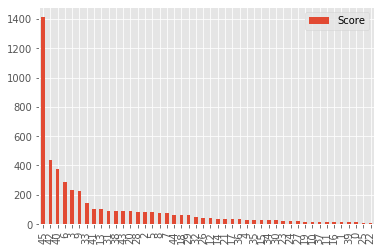

In [130]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### K-Nearest Neighbors

#### SMOTE

In [43]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set recall score: ", recall_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set recall score:  0.9974509304104002
KNN Baseline Validation Set recall score:  0.8910891089108911


In [44]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = business_score)

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [45]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 71}
KNN Grid Search Training set Recall score:  0.9604894213612032
KNN Grid Search Validation set Recall score:  0.9405940594059405
KNN Grid Search Validation set business score:  0.7169309987444251


#### imblearn

In [46]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set recall score: ", recall_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set recall score:  0.99974509304104
KNN Baseline Validation Set recall score:  0.801980198019802


In [47]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = business_score)

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   43.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [48]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 71}
KNN Grid Search Training set Recall score:  0.912566913076727
KNN Grid Search Validation set Recall score:  0.9207920792079208
KNN Grid Search Validation set business score:  0.6985512729638432


#### Comparing SMOTE and imblearn

In [49]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.7169309987444251 
imblearn KNN business score:  0.6985512729638432


In [139]:
recall_scores.loc[2] = 'KNN', round(SMOTE_knn, 2)

In [157]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[832, 149],
       [ 10,  91]])

### Support Vector Machine

#### SMOTE

In [50]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

SVC(class_weight='balanced')

In [51]:
# baseline score
svm_train_recall = recall_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

SMOTE: 
SVM BaseLine Train Set Recall Score: 0.9604894213612032
SVM BaseLine Validation Set Recall Score: 0.900990099009901


In [131]:
# grid search 
params = {'C': np.logspace(0,3,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = business_score)
svm_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([   1.        ,    2.15443469,    4.64158883,   10.        ,
         21.5443469 ,   46.41588834,  100.        ,  215.443469  ,
        464.15888336, 1000.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [132]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = businessgain(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 464.15888336127773, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  1.0
SVM Grid Search Validation set Recall score:  0.8712871287128713
Test Set business Score: 0.6982802025760915


#### imblearn

In [55]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

SVC(class_weight='balanced')

In [56]:
# baseline score
svm_train_recall = recall_score(y_ros, svm.predict(X_ros))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

imblearn: 
SVM BaseLine Train Set Recall Score: 0.9263318888605659
SVM BaseLine Validation Set Recall Score: 0.9405940594059405


In [133]:
# grid search 
params = {'C': np.logspace(-1,3,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = business_score)
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.78255940e-01, 7.74263683e-01, 2.15443469e+00,
       5.99484250e+00, 1.66810054e+01, 4.64158883e+01, 1.29154967e+02,
       3.59381366e+02, 1.00000000e+03]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [134]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 359.38136638046257, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  1.0
SVM Grid Search Validation set Recall score:  0.5148514851485149
Test Set business Score: -0.03489252635871148


#### Comparing SMOTE and imblearn

In [135]:
print('SMOTE svm business score: ', SMOTE_svm, '\nimblearn svm business score: ', imblearn_svm)

SMOTE svm business score:  0.6982802025760915 
imblearn svm business score:  -0.03489252635871148


In [140]:
recall_scores.loc[3] = 'SVC', round(SMOTE_svm, 2)

In [60]:
#recall = TP / (TP+FN) 
confusion_matrix(y_test, best_svm.predict(X_test))

array([[962,  19],
       [ 48,  53]])

### Discriminant Analysis

#### SMOTE

In [61]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train_Bal, y_train_Bal)

LinearDiscriminantAnalysis()

In [62]:
y_predict = LDA.predict(X_test)
print("SMOTE: \nLDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("LDA Baseline validation set business score: ", businessgain(y_test,y_predict))

SMOTE: 
LDA Baseline validation set recall score:  0.8415841584158416
LDA Baseline validation set business score:  0.6600984965974899


In [63]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train_Bal, y_train_Bal)
y_predict = QDA.predict(X_test)

print("QDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("QDA Baseline validation set business score: ", businessgain(y_test,y_predict))


QDA Baseline validation set recall score:  0.900990099009901
QDA Baseline validation set business score:  0.716160466748603


/home/annie/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Random Forest

In [16]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.8910891089108911


In [21]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 13 s, sys: 274 ms, total: 13.2 s
Wall time: 10min


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [22]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 80}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.8910891089108911
RF Grid Search Validation set Business score:  0.7618767760156921


Text(0.5, 0, 'Random Forest Feature Importance')

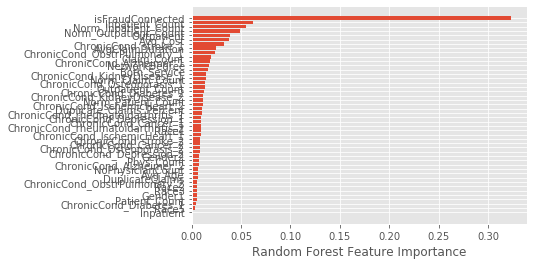

In [24]:
#plt.barh(X_train_Bal.columns, best_RF.feature_importances_)
sorted_idx = best_RF.feature_importances_.argsort()
plt.barh(X_train_Bal.columns[sorted_idx], best_RF.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [31]:
# feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))
# test2 = 
# # summarize feature importance
# for i,v in enumerate(importance):
#     feature_importance.loc[i] = X_train_Bal.columns[i], np.abs(v)
list_of_tuples = list(zip(X_train_Bal.columns, best_RF.feature_importances_)) 
df = pd.DataFrame(list_of_tuples, columns = ['Feature', 'Score']) 

# Assign data to tuples. 
df.sort_values(by='Score', ascending=False)

,Feature,Score
45,isFraudConnected,0.322873
5,Inpatient_Count,0.062388
7,Norm_Inpatient_Count,0.054912
8,Norm_Outpatient_Count,0.049142
44,Outpatient,0.038753
12,Avg_Cost,0.038041
38,ChronicCond_stroke_1,0.032605
11,AvgClaimDuration,0.024565
26,ChronicCond_ObstrPulmonary_1,0.023342
3,Claim_Count,0.019408


#### imblearn

In [67]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set Recall Score:', recall_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.900990099009901


In [68]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 9.78 s, sys: 276 ms, total: 10.1 s
Wall time: 3min 47s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [69]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 21, 'n_estimators': 60}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.8910891089108911
RF Grid Search Validation set Business score:  0.7674135328718985


#### comparing SMOTE and imblearn

In [70]:
print('SMOTE rf business score: ', SMOTE_rf, '\nimblearn rf business score: ', imblearn_rf)

SMOTE rf business score:  0.7835243418324473 
imblearn rf business score:  0.7674135328718985


In [141]:
recall_scores.loc[4] = 'RF', round(SMOTE_rf, 2)

### XG BOOST 

In [107]:
from xgboost import XGBClassifier

#SMOTE
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [108]:
print('SMOTE: \nXGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set Recall Score: 0.99974509304104
XGB BaseLine Validation Set Recall Score: 0.9207920792079208


In [109]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [100,200,300],
                 'learning_rate': [0.1, 1, 1.5],
                 'n_estimators': [5,10,13] ,
                 'max_depth': [1,3,5],
                 'subsample': [0.9]
                 } 

In [110]:
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 1.82 s, sys: 25.3 ms, total: 1.84 s
Wall time: 14.2 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [111]:
grid_search_xgb.best_params_

{'learning_rate': 1,
 'max_depth': 3,
 'n_estimators': 10,
 'scale_pos_weight': 200,
 'subsample': 0.9}

In [112]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9603960396039604
XGB BaseLine Validation Set business Score: 0.8515826185053409


#### imblearn

In [95]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set Recall Score:', recall_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9108910891089109


In [104]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [100,150,200],
                 'learning_rate': [0.5, 1, 1.5],
                 'n_estimators': [15,17,20] ,
                 'max_depth': [7,10,15],
                 'subsample': [0.9]
                 } 
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=business_score, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 6.39 s, sys: 103 ms, total: 6.49 s
Wall time: 47.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [105]:
grid_search_xgb.best_params_

{'learning_rate': 1,
 'max_depth': 15,
 'n_estimators': 17,
 'scale_pos_weight': 100,
 'subsample': 0.9}

In [106]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9306930693069307
XGB BaseLine Validation Set business Score: 0.8438530752358744


#### comparing SMOTE and imblearn

In [113]:
print('SMOTE xgb business score: ', SMOTE_xgb, '\nimblearn xgb business score: ', imblearn_xgb)

SMOTE xgb business score:  0.8515826185053409 
imblearn xgb business score:  0.8438530752358744


In [142]:
recall_scores.loc[5] = 'XGBoost', round(SMOTE_xgb, 2)

In [81]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[781, 200],
       [  2,  99]])

,Model,Score
0,Logistic,0.81
1,SGD,0.79
2,KNN,0.72
3,SVC,0.70
4,RF,0.78
5,XGBoost,0.85


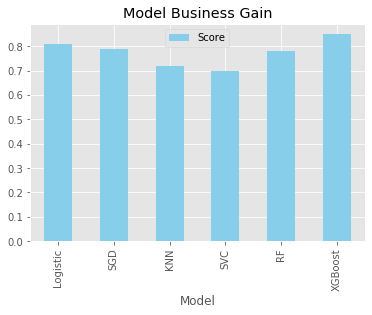

In [143]:
recall_scores.plot.bar(x = 'Model', color = 'skyblue')
plt.title('Model Business Gain')
recall_scores